In [1]:
import sys
sys.path.append("../src/python")

import calendar
import datetime
import pandas as pd
import numpy as np
import xarray as xr
import json

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# bias correction
from sklearn.preprocessing import QuantileTransformer

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


current XLA device: cpu


In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
agg_ops = {
    'Tair_degC_200cm': [('Tair_mean', 'mean'), ('Tair_min','min'),('Tair_max', 'max')],
    'RadNet_W/m2': [('RadNet_mean','mean')],
    'prec_mm/hour': [('prec','sum')],
}
bayelva_dataset_hourly = pd.read_csv("../data/input/Bayelva_level2.dat", comment="#")
bayelva_dataset_hourly["UTC"] = pd.to_datetime(bayelva_dataset_hourly["Datetime_UTC"])
bayelva_dataset_hourly = bayelva_dataset_hourly.set_index("UTC")[:"2023"]
bayelva_dataset = bayelva_dataset_hourly[["Tair_degC_200cm", "prec_mm/hour", "RadNet_W/m2", "Tsoil_degC_10cm", "VWC_m3/m3_10cm"]] \
    .resample("1d").agg(agg_ops, axis=1) \
    .droplevel(level=0, axis=1)
bayelva_dataset_counts = bayelva_dataset_hourly[["Tair_degC_200cm", "prec_mm/hour", "RadNet_W/m2", "Tsoil_degC_10cm", "VWC_m3/m3_10cm"]] \
    .resample("1d").count()
bayelva_dataset_counts = bayelva_dataset_counts.rename({k: v for k,v in zip(bayelva_dataset_counts.columns, bayelva_dataset.columns)}, axis=1)
bayelva_dataset[bayelva_dataset_counts < 24] = np.nan
bayelva_dataset["prec_obs"] = bayelva_dataset.prec
bayelva_dataset["prec"] = bayelva_dataset.prec.where(bayelva_dataset["Tair_max"] > 0, np.nan)
one_hot_months = pd.DataFrame(jax.nn.one_hot(bayelva_dataset.index.month.values-1, 12), columns=[f"{calendar.month_name[i+1]}" for i in range(12)])
bayelva_dataset = pd.concat([bayelva_dataset, one_hot_months.set_index(bayelva_dataset.index)], axis=1)
bayelva_dataset

Tair_mean  Tair_min  Tair_max  RadNet_mean  prec  prec_obs  \
UTC                                                                      
1998-09-13        NaN       NaN       NaN          NaN   NaN       NaN   
1998-09-14        NaN       NaN       NaN          NaN   NaN       NaN   
1998-09-15  -2.453583       NaN    -0.399   -11.620833   NaN       NaN   
1998-09-16  -0.311792       NaN     0.507     2.484583   NaN       NaN   
1998-09-17   0.114250       NaN     1.249     3.491667   NaN       NaN   
...               ...       ...       ...          ...   ...       ...   
2023-12-27  -5.921833    -8.890    -4.181   -22.552500   NaN       0.0   
2023-12-28  -6.432333    -9.620    -3.361   -24.093333   NaN       0.0   
2023-12-29  -4.120417    -7.186    -1.933   -23.425417   NaN       0.0   
2023-12-30  -0.203583    -1.768     0.666   -17.880833   0.0       0.0   
2023-12-31  -0.351083    -1.532     0.932   -19.070833   0.0       0.0   

            January  February  March  April  May  June  July  August  \
UTC                                                                    
1998-09-13      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
1998-09-14      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
1998-09-15      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
1998-09-16      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
1998-09-17      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
...             ...       ...    ...    ...  ...   ...   ...     ...   
2023-12-27      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
2023-12-28      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
2023-12-29      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
2023-12-30      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   
2023-12-31      0.0       0.0    0.0    0.0  0.0   0.0   0.0     0.0   

            September  October  November  December  
UTC                                                 
1998-09-13        1.0      0.0       0.0       0.0  
1998-09-14        1.0      0.0       0.0       0.0  
1998-09-15        1.0      0.0       0.0       0.0  
1998-09-16        1.0      0.0       0.0       0.0  
1998-09-17        1.0      0.0       0.0       0.0  
...               ...      ...       ...       ...  
2023-12-27        0.0      0.0       0.0       1.0  
2023-12-28        0.0      0.0       0.0       1.0  
2023-12-29        0.0      0.0       0.0       1.0  
2023-12-30        0.0      0.0       0.0       1.0  
2023-12-31        0.0      0.0       0.0       1.0  

[9241 rows x 18 columns]

In [3]:
bayelva_dataset.describe()

Tair_mean     Tair_min     Tair_max  RadNet_mean         prec  \
count  8661.000000  8150.000000  8599.000000  8029.000000  2242.000000   
mean     -4.181065    -6.626465    -1.828823     4.628881     1.955442   
std       8.264146     9.003234     7.748293    52.445709     5.284413   
min     -31.633750   -33.385000   -28.959000   -99.240417     0.000000   
25%     -10.123542   -13.713750    -7.037500   -29.183333     0.000000   
50%      -3.071458    -5.568500    -0.694000    -9.027500     0.100000   
75%       2.606333     1.165000     4.194000    23.779583     1.400000   
max      14.587917    11.830000    17.565000   244.418750    81.100000   

          prec_obs      January     February        March        April  \
count  4634.000000  9241.000000  9241.000000  9241.000000  9241.000000   
mean      0.973025     0.083865     0.076399     0.083865     0.081160   
std       3.829768     0.277201     0.265649     0.277201     0.273096   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.100000     0.000000     0.000000     0.000000     0.000000   
max      81.100000     1.000000     1.000000     1.000000     1.000000   

               May         June         July       August    September  \
count  9241.000000  9241.000000  9241.000000  9241.000000  9241.000000   
mean      0.083865     0.081160     0.083865     0.083865     0.083108   
std       0.277201     0.273096     0.277201     0.277201     0.276060   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           October     November     December  
count  9241.000000  9241.000000  9241.000000  
mean      0.087220     0.084406     0.087220  
std       0.282172     0.278011     0.282172  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000

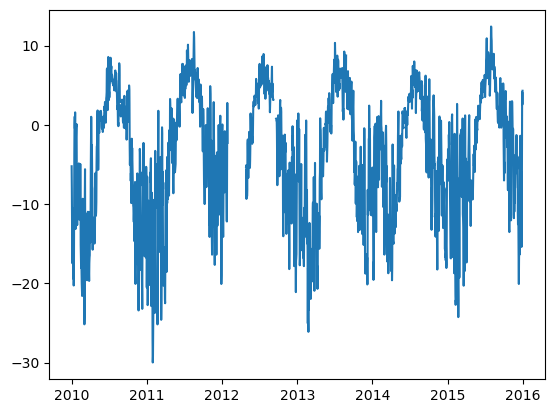

In [4]:
plt.plot(bayelva_dataset.Tair_mean["2010":"2015"])

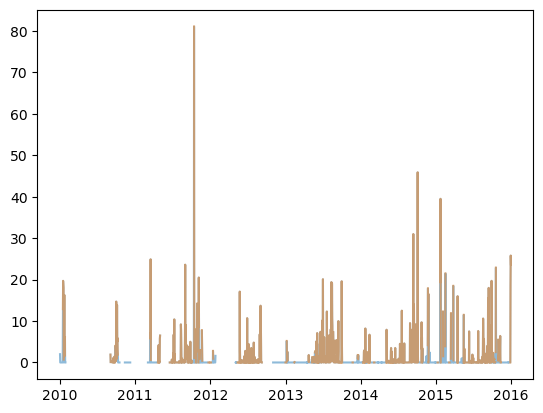

In [5]:
plt.plot(bayelva_dataset[["prec_obs", "prec"]]["2010":"2015"], alpha=0.5)

In [6]:
# ERA5-Land snowfall data
# sf_data = xr.load_dataset("../data/input/bayelva_era5_sf_1990-2023.nc")
# ERA5-Land total precipitation
tp_data = xr.load_dataset("../data/input/bayelva_era5_total_precipitation_1979-2023.nc")
# ERA5-Land 2m air temp.
t2m_data = xr.load_dataset("../data/input/bayelva_era5_2m_temperature_1979-2023.nc")

In [7]:
# select nearest point to Bayelva station
tp_hourly = tp_data.sel(longitude=11.83421, latitude=78.92083, method="nearest").tp
# select the zero'th hour of each day which represents the accumulation over the last 24 hours
# https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790
tp_daily = tp_hourly.sel(time=datetime.time(0))*1000
tp_daily = (tp_daily - 0.5).clip(0.0)
tp_daily

<xarray.DataArray 'tp' (time: 16436)> Size: 131kB
array([1.3108478 , 0.        , 2.64259237, ..., 0.05257346, 2.55094793,
       0.        ])
Coordinates:
    longitude  float32 4B 11.8
    latitude   float32 4B 78.9
  * time       (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31

In [8]:
t2m_hourly = t2m_data.sel(longitude=11.83421, latitude=78.92083, method="nearest").t2m
t2m_daily_mean = t2m_hourly.resample(time="1D").mean()
t2m_daily_min = t2m_hourly.resample(time="1D").min()
t2m_daily_max = t2m_hourly.resample(time="1D").max()

In [9]:
bayelva_dataset["Tair_era5"] = t2m_daily_mean.sel(time=bayelva_dataset.index, method="nearest")

/sparc/personal_accounts/03_PhD/Brian/repos/WeatherGen/.CondaPkg/env/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<Axes: xlabel='month'>

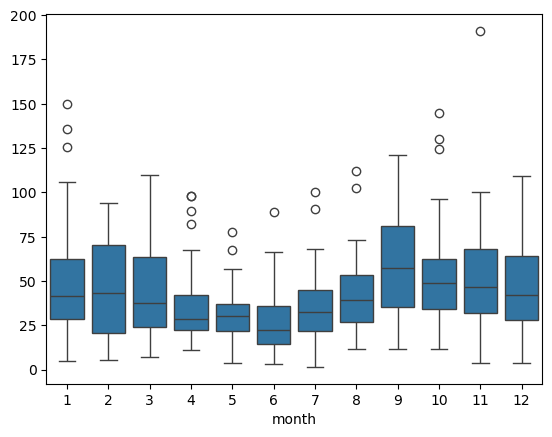

In [10]:
tp_monthly = tp_daily.resample(time="1M").sum()
sns.boxplot(x=tp_monthly.time.dt.month, y=tp_monthly.values)

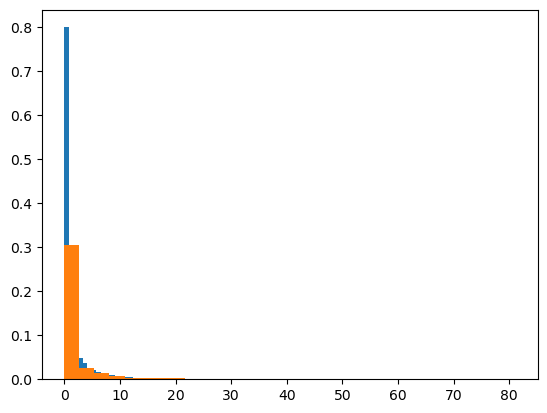

In [11]:
plt.hist(tp_daily.values, bins=30, density=True)
plt.hist(bayelva_dataset.prec.values, bins=30, density=True);

In [12]:
bayelva_dataset["prec_era5"] = tp_daily.sel(time=bayelva_dataset.index, method="nearest")
tp_era5_mapped = wx.utils.quantile_map_nonparametic(
    tp_daily.values,
    bayelva_dataset["prec_obs"].dropna().values,
    tp_daily.sel(time=bayelva_dataset.index, method="nearest").values
)
t2m_era5_mapped = wx.utils.quantile_map_nonparametic(
    t2m_daily_mean.values,
    bayelva_dataset["Tair_mean"].dropna().values,
    t2m_daily_mean.sel(time=bayelva_dataset.index, method="nearest").values
)
rng = np.random.default_rng(seed=1234)
bayelva_dataset["prec"] = tp_era5_mapped #bayelva_dataset["prec_obs"].where(np.logical_and(np.isfinite(bayelva_dataset["prec_obs"]), bayelva_dataset["Tair_max"] > 0), tp_era5_mapped)
jitter = rng.random(bayelva_dataset["prec"].shape)*0.1 - 0.1
bayelva_dataset["prec"] = bayelva_dataset["prec"].where(
    bayelva_dataset["prec"] <= 0,
    np.maximum(0, bayelva_dataset["prec"] + jitter)
)

In [13]:
bayelva_era5_mapped = pd.DataFrame(np.stack([t2m_era5_mapped, tp_era5_mapped]).T, columns=["Tair_mean", "precip"]).set_index(bayelva_dataset.index)
bayelva_era5_mapped.to_csv("../data/product/bayelva_era5_corrected.csv")
bayelva_dataset_gapfilled = bayelva_dataset[["Tair_mean","prec"]].where(~bayelva_dataset[["Tair_mean","prec"]].isna(), bayelva_era5_mapped)
bayelva_dataset_gapfilled.to_csv("../data/product/bayelva_era5_Tair_precip_1998-2023.csv")

<Axes: xlabel='UTC'>

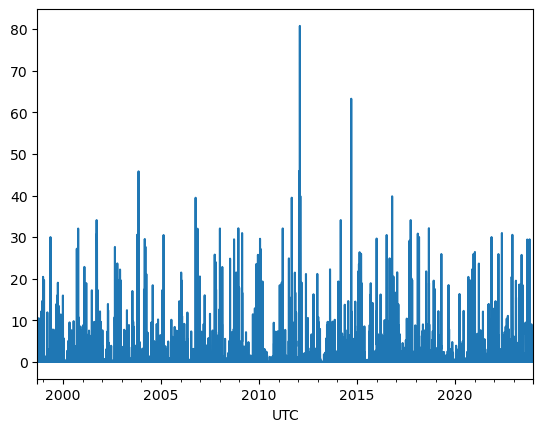

In [14]:
bayelva_dataset["prec"].plot()

In [15]:
bayelva_dataset["prec"].autocorr()

0.24910164530005735

In [16]:
bayelva_dataset["prec_obs"].autocorr()

0.280427261019755

<Axes: xlabel='UTC', ylabel='prec'>

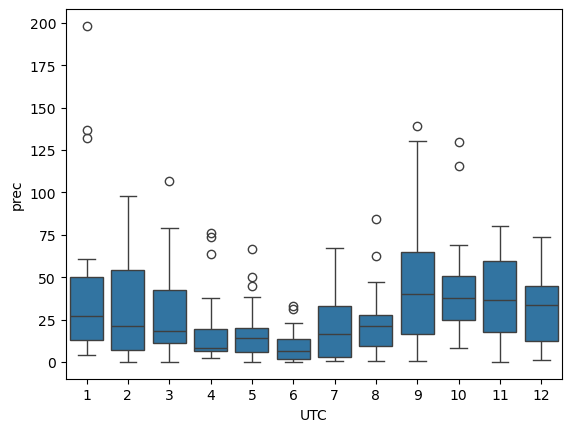

In [17]:
bayelva_prec_monthly = bayelva_dataset.prec.resample("1ME").sum()
sns.boxplot(x=bayelva_prec_monthly.index.month, y=bayelva_prec_monthly)

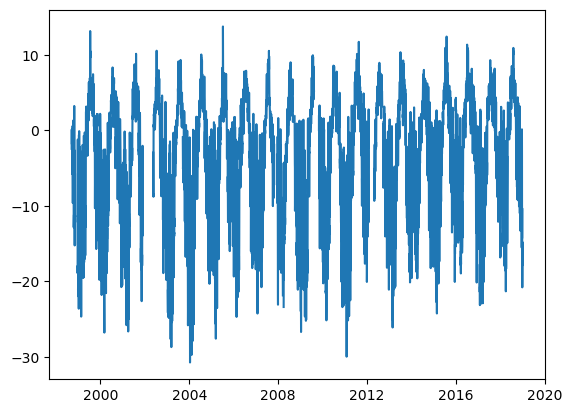

In [18]:
plt.plot(bayelva_dataset.Tair_mean["1998":"2018"])
# plt.plot(bayelva_dataset.Tavg_era5["1998":"2018"], color='purple', alpha=0.6)

In [141]:
bayelva_dataset_train = bayelva_dataset["1998":"2018"]
Tair_freqs = wx.utils.truncated_fft(bayelva_dataset_gapfilled["1998":"2018"].Tair_mean.values, nfreqs=1)["freq"]
prec_freqs = wx.utils.truncated_fft(bayelva_dataset_gapfilled["1998":"2018"].prec.values, nfreqs=1)["freq"]

In [142]:
1/Tair_freqs

0    370.75
Name: freq, dtype: float64

In [143]:
1/prec_freqs

0    370.75
Name: freq, dtype: float64

In [144]:
predictors = list(one_hot_months.columns)
wgen_args = (wx.wgen_glm_v3,)
wgen_kwargs = dict(order=2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs,
                   predictors=predictors, pred_effect_scale=0.1)
wgen = wx.WGEN(bayelva_dataset_train, *wgen_args, **wgen_kwargs)

In [145]:
from numpyro.infer import Predictive, SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoDelta

guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median, init_scale=0.1)
# guide = AutoDelta(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
optimizer = numpyro.optim.Adam(1e-4)
svi = SVI(wgen.step, guide, optimizer, loss=TraceGraph_ELBO())
prng = random.PRNGKey(1234)

In [146]:
num_iter = 50_000
svi_result = svi.run(prng, num_iter, subsample_time=2*365)

100%|██████████| 50000/50000 [01:59<00:00, 417.51it/s, init loss: 226718.5312, avg. loss [47501-50000]: 31020.9424]


In [147]:
svi_mode = guide.get_posterior(svi_result.params).mean

In [148]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=1000)
posterior_samples = posterior_sampler(prng)
posterior_mean = {k: v.mean(axis=0) for k,v in posterior_samples.items() if k != '_auto_latent'}
posterior_std = {k: v.std(axis=0) for k,v in posterior_samples.items() if k != '_auto_latent'}
{k: (posterior_mean[k], posterior_std[k]) for k in posterior_mean.keys()}

{'Tavg_lag': (Array([-0.07876495,  0.8836915 ], dtype=float32),
  Array([0.01523428, 0.00957328], dtype=float32)),
 'Tavg_pred': (Array([-0.60202533, -0.70385486, -0.89101696, -1.0858883 , -0.6283781 ,
          0.09397716,  0.7189484 ,  1.2101554 ,  1.0235497 ,  0.353848  ,
         -0.3822182 , -0.75908303, -0.84477484], dtype=float32),
  Array([0.07211889, 0.21159841, 0.23128922, 0.24989784, 0.22832762,
         0.12946296, 0.08839031, 0.12600659, 0.10819898, 0.11194894,
         0.16056319, 0.19599001, 0.19941136], dtype=float32)),
 'Tavg_seasonal': (Array([-0.51197493, -0.2191251 ], dtype=float32),
  Array([0.0786237, 0.0570225], dtype=float32)),
 'Tavg_seasonal&lag1': (Array([-0.00120373, -0.02759569], dtype=float32),
  Array([0.01750183, 0.01447949], dtype=float32)),
 'Trange_mean_Tavg': (Array([0.1628057], dtype=float32),
  Array([0.02432027], dtype=float32)),
 'Trange_mean_pred': (Array([ 2.5377946 ,  1.4465214 ,  1.4121889 ,  1.5452299 ,  2.1308284 ,
          1.5978681 ,  0.

In [149]:
# from numpyro.infer import MCMC, NUTS, HMCECS

# map_proxy = HMCECS.taylor_proxy(posterior_mean, 1)
# mcmc_kernel = NUTS(wgen.step, init_strategy=numpyro.infer.init_to_median)
# mcmc_kernel = HMCECS(mcmc_kernel, num_blocks=100, proxy=map_proxy)
# mcmc = MCMC(mcmc_kernel, num_warmup=500, num_samples=1000, num_chains=4, chain_method="parallel")
# prng = random.PRNGKey(1234)
# mcmc.run(prng, subsample_time=1000)
# mcmc.print_summary()

In [150]:
seed = 1234
prng = random.PRNGKey(seed)
wgen_full = wx.WGEN(bayelva_dataset, *wgen_args, **wgen_kwargs)
svi_predictive = Predictive(wgen_full.simulate, posterior_samples=posterior_samples, parallel=True)
svi_preds = svi_predictive(prng)

In [151]:
import h5py

# save to HDF5 file
with h5py.File(f"../data/product/bayelva_wgen_glm_v3_seed={seed}.hdf5", "w") as h5f:
    h5f.create_dataset("time", data=wgen_full.timestamps[:,wgen_full.first_valid_idx:,:])
    for k, v in svi_preds.items():
        h5f.create_dataset(k, data=v)

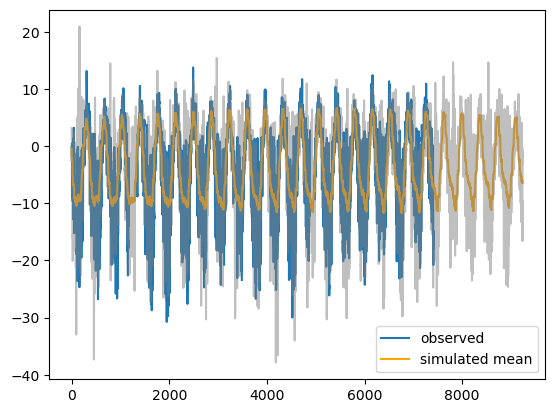

In [152]:
Tavg_sims = svi_preds["Tavg"].squeeze().T
sim_mean = Tavg_sims.mean(axis=1)
plt.plot(wgen.obs["Tavg"].squeeze(), label="observed")
plt.plot(sim_mean, label="simulated mean", c='orange')
plt.plot(Tavg_sims[:,:1], c='gray', alpha=0.5)
plt.legend();

In [153]:
svi_preds["Tavg"].squeeze().shape

(1000, 9239)

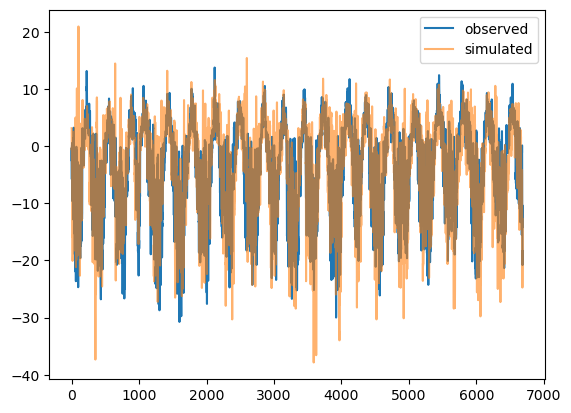

In [154]:
plt.plot(wgen.obs["Tavg"].squeeze()[wgen.valid_idx], label="observed")
plt.plot(svi_preds["Tavg"].squeeze()[0,wgen.valid_idx-wgen.first_valid_idx], label="simulated", alpha=0.6)
plt.legend();

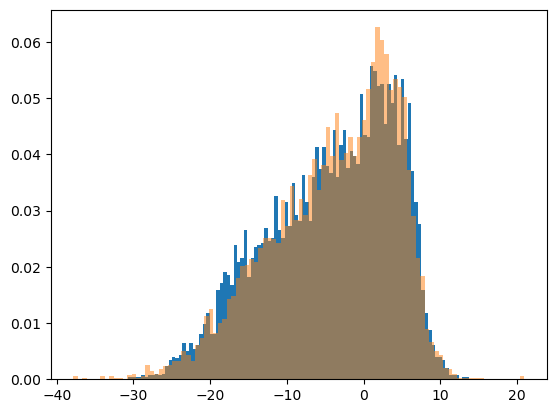

In [155]:
plt.hist(wgen.obs["Tavg"][0,wgen.valid_idx], density=True, bins=100)
plt.hist(svi_preds["Tavg"].squeeze()[0,wgen.valid_idx-wgen.first_valid_idx], density=True, alpha=0.5, bins=100);

Text(0, 0.5, 'simulated')

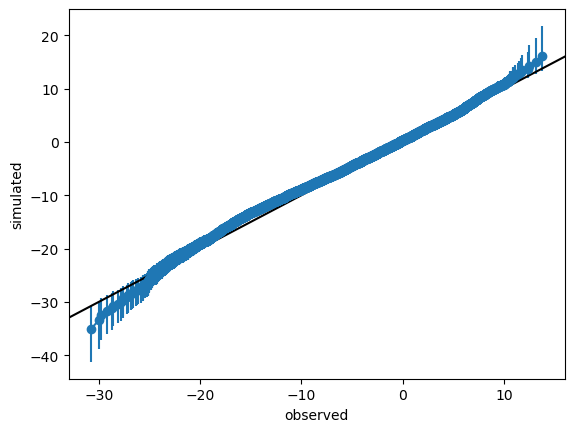

In [156]:
Tavg_preds = svi_preds['Tavg'].squeeze()[:,wgen.valid_idx].T.sort(axis=0)
Tavg_pred_mid = np.median(Tavg_preds, axis=1)
Tavg_obs = wgen.obs['Tavg'].squeeze()[wgen.valid_idx].sort()
# plt.scatter(prec_obs, prec_preds.mean(axis=1))
plt.errorbar(Tavg_obs, Tavg_pred_mid, yerr=np.stack([Tavg_pred_mid - np.quantile(Tavg_preds, 0.05, axis=1), np.quantile(Tavg_preds, 0.95, axis=1) - Tavg_pred_mid]), marker="o")
plt.axline((0,0),slope=1,c='black')
plt.xlabel("observed")
plt.ylabel("simulated")

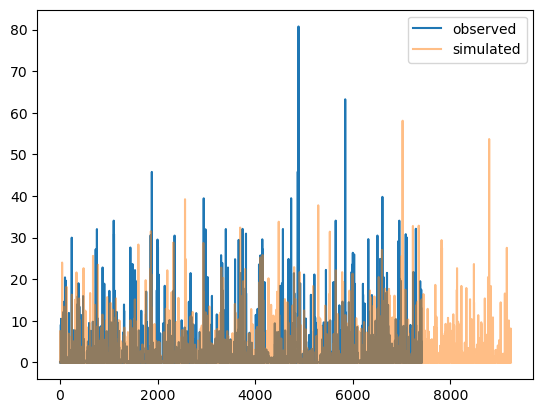

In [157]:
plt.plot(wgen.obs["prec"].squeeze()[wgen.first_valid_idx:], label="observed")
plt.plot(svi_preds["prec"].squeeze()[0,:], label="simulated", alpha=0.5);
plt.legend();

(-30.0, 20.0)

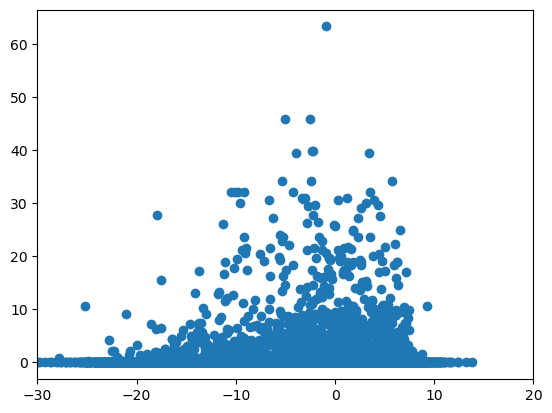

In [158]:
plt.scatter(wgen.obs["Tavg"], wgen.obs["prec"])
plt.xlim((-30,20))

In [159]:
# plt.scatter(svi_preds["Tavg"], svi_preds["prec"])
# plt.xlim((-30,20))

In [160]:
(wgen.obs["prec"] > 0).mean()

Array(0.26190156, dtype=float32)

In [161]:
(svi_preds["prec"] > 0).mean()

Array(0.28611666, dtype=float32)

In [162]:
svi_preds["prec"].max()

Array(150.23703, dtype=float32)

In [163]:
(svi_preds["prec"].max(axis=1) > 100).sum()

Array(21, dtype=int32)

(0.0, 20.0)

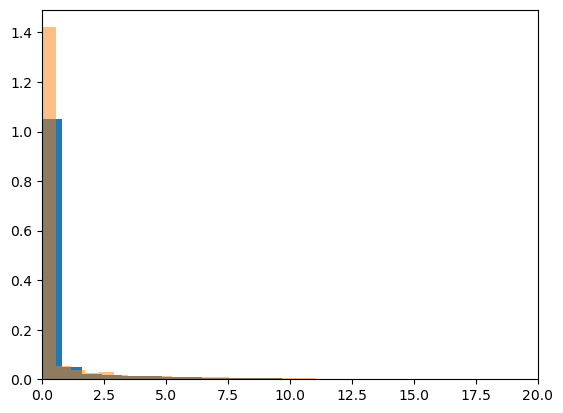

In [164]:
plt.hist(wgen.obs["prec"].squeeze(), bins=100, density=True)
plt.hist(svi_preds["prec"].squeeze()[0,:], alpha=0.5, bins=100, density=True);
plt.xlim((0,20))

Text(0, 0.5, 'simulated')

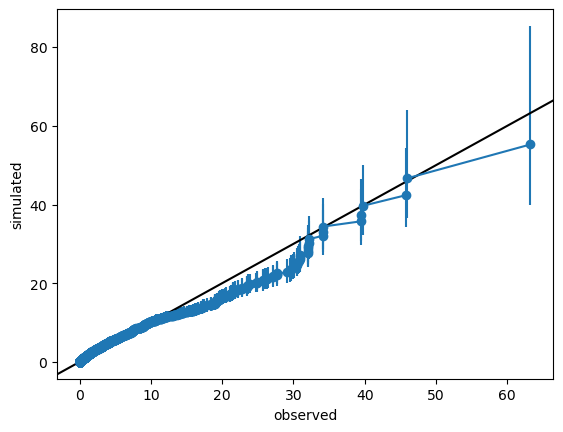

In [165]:
prec_preds = svi_preds['prec'].squeeze()[:,wgen.valid_idx].T.sort(axis=0)
prec_pred_mid = np.median(prec_preds, axis=1)
prec_obs = wgen.obs['prec'].squeeze()[wgen.valid_idx].sort()
# plt.scatter(prec_obs, prec_preds.mean(axis=1))
plt.errorbar(prec_obs, prec_pred_mid, yerr=np.stack([prec_pred_mid - np.quantile(prec_preds, 0.05, axis=1), np.maximum(0, np.quantile(prec_preds, 0.95, axis=1) - prec_pred_mid)]), marker="o")
plt.axline((0,0),slope=1,c='black')
plt.xlabel("observed")
plt.ylabel("simulated")

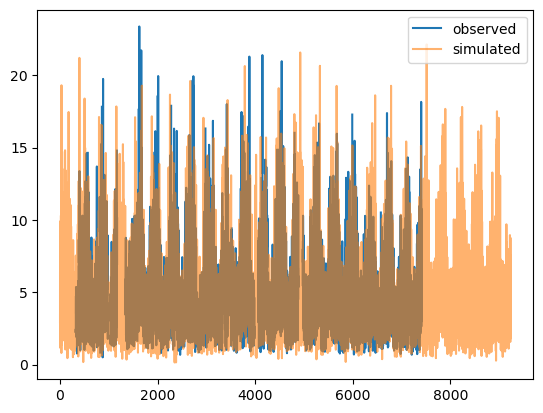

In [166]:
plt.plot(wgen.obs["Trange"].squeeze()[wgen.first_valid_idx:], label="observed")
plt.plot(svi_preds["Trange"].squeeze()[0,:], label="simulated", alpha=0.6)
plt.legend();

ValueError: x and y must have same first dimension, but have shapes (7413,) and (9239,)

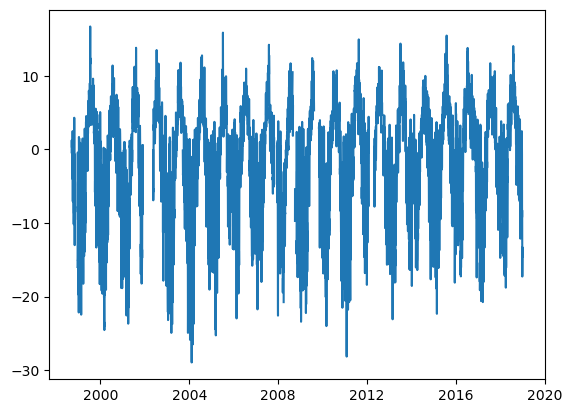

In [167]:
plt.plot(bayelva_dataset_train.Tair_max[wgen.first_valid_idx:], label="observed")
plt.plot(bayelva_dataset_train.index[wgen.first_valid_idx:], svi_preds["Tmax"].squeeze()[0,:], label="simulated", alpha=0.6)
plt.legend();

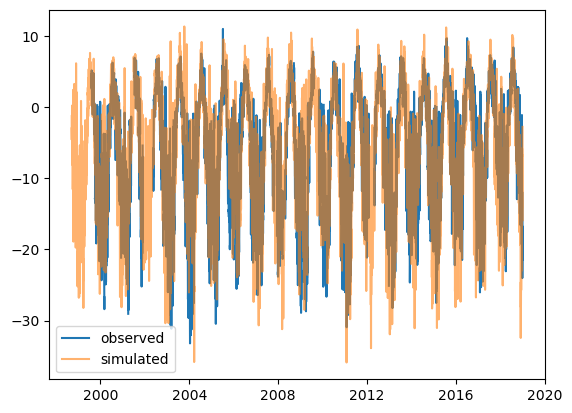

In [ ]:
plt.plot(bayelva_dataset_train.Tair_min[wgen.first_valid_idx:], label="observed")
plt.plot(bayelva_dataset_train.index[wgen.first_valid_idx:], svi_preds["Tmin"].squeeze()[0,:], label="simulated", alpha=0.6)
plt.legend();

In [ ]:
assert (svi_preds["Tmax"] > svi_preds["Tmin"]).all()